# Wikipedia user activity analysis

In this project we will analyze Wikipedia users activity logs. The analysis is based on Wikimedia Foundation data analysis task that can be found [here](https://github.com/wikimedia-research/Discovery-Hiring-Analyst-2016).

## 1. Frame the problem

The analysed dataset contains event logging data which is used by Wikimedia to track a variety of performance and usage metrics to help them build various metrics and make data-driven strategic decisions.

The analysis has five main aims - as defined by Wikimedia:
1. What is our daily overall clickthrough rate (the proportion of search sessions where the user clicked on one of the results displayed)? How does it vary between the groups?
2. Which results do people tend to try first? How does it change day-to-day?
3. What is our daily overall zero results rate (the proportion of searches that yielded 0 results)? How does it vary between the groups?
4. Let session length be approximately the time between the first event and the last event in a session. Choose a variable from the dataset and describe its relationship to session length. Visualize the relationship.
5. Summarize your findings in an executive summary.

That means that we will build two metrics needed to answer these questions: clickthrough rate and zero results rate.

## 2. Get the data

We will use a dataset published by Wikimedia Foundation that can be found [here](https://github.com/wikimedia-research/Discovery-Hiring-Analyst-2016).

The dataset comes from a tracking schema that is used in Wikimedia Foundation for assessing user satisfaction. Desktop users are randomly sampled to be anonymously tracked by this schema to estimate how long users stay on the pages they visit. The dataset contains over a week of event logging data.


| Column          | Value   | Description                                                                       |
|:----------------|:--------|:----------------------------------------------------------------------------------|
| uuid            | string  | Universally unique identifier (UUID) for backend event handling.                  |
| timestamp       | integer | The date and time (UTC) of the event, formatted as YYYYMMDDhhmmss.                |
| session_id      | string  | A unique ID identifying individual sessions.                                      |
| group           | string  | A label ("a" or "b").                                     |
| action          | string  | Identifies in which the event was created. See below.                             |
| checkin         | integer | How many seconds the page has been open for.                                      |
| page_id         | string  | A unique identifier for correlating page visits and check-ins.                    |
| n_results       | integer | Number of hits returned to the user. Only shown for searchResultPage events.      |
| result_position | integer | The position of the visited page's link on the search engine results page (SERP). |


An event's action field can have following values:
* `searchResultPage`: when a new search is performed and the user is shown a SERP.
* `visitPage`: when the user clicks a link in the results.
* `checkin`: when the user has remained on the page for a pre-specified amount of time.

Example session can look like this:

|uuid                             |      timestamp|session_id       |group |action           | checkin|page_id          | n_results| result_position|
|:--------------------------------|:--------------|:----------------|:-----|:----------------|-------:|:----------------|---------:|---------------:|
|4f699f344515554a9371fe4ecb5b9ebc | 20160305195246|001e61b5477f5efc |b     |searchResultPage |      NA|1b341d0ab80eb77e |         7|              NA|
|759d1dc9966353c2a36846a61125f286 | 20160305195302|001e61b5477f5efc |b     |visitPage        |      NA|5a6a1f75124cbf03 |        NA|               1|
|77efd5a00a5053c4a713fbe5a48dbac4 | 20160305195312|001e61b5477f5efc |b     |checkin          |      10|5a6a1f75124cbf03 |        NA|               1|
|42420284ad895ec4bcb1f000b949dd5e | 20160305195322|001e61b5477f5efc |b     |checkin          |      20|5a6a1f75124cbf03 |        NA|               1|
|8ffd82c27a355a56882b5860993bd308 | 20160305195332|001e61b5477f5efc |b     |checkin          |      30|5a6a1f75124cbf03 |        NA|               1|
|2988d11968b25b29add3a851bec2fe02 | 20160305195342|001e61b5477f5efc |b     |checkin          |      40|5a6a1f75124cbf03 |        NA|               1|

This user's search query returned 7 results, they clicked on the first result, and stayed on the page between 40 and 50 seconds.

Let's load the data.

In [199]:
import pandas as pd

In [200]:
activity_df = pd.read_csv("datasets/events_log.csv")

Now we can check how the data looks like.

In [236]:
activity.head(20)

,uuid,timestamp,session_id,group,action,checkin,page_id,n_results,result_position
0,00000736167c507e8ec225bd9e71f9e5,2.016030e+13,78245c2c3fba013a,b,searchResultPage,NaN,cbeb66d1bc1f1bc2,5.0,NaN
1,00000c69fe345268935463abbfa5d5b3,2.016031e+13,c559c3be98dca8a4,a,searchResultPage,NaN,eb658e8722aad674,10.0,NaN
2,00003bfdab715ee59077a3670331b787,2.016030e+13,760bf89817ce4b08,a,checkin,30.0,f99a9fc1f7fdd21e,NaN,NaN
3,0000465cd7c35ad2bdeafec953e08c1a,2.016030e+13,fb905603d31b2071,a,checkin,60.0,e5626962a6939a75,NaN,10.0
4,000050cbb4ef5b42b16c4d2cf69e6358,2.016030e+13,c2bf5e5172a892dc,a,checkin,30.0,787dd6a4c371cbf9,NaN,NaN
5,0000a6af2baa5af1be2431e84cb01da1,2.016030e+13,f6840a9614c527ad,a,checkin,180.0,6fb7b9ea87012975,NaN,NaN
6,0000cd61e11d5371adf974703cd4f7e7,2.016030e+13,51f4d3b6a8688e56,a,checkin,240.0,8ad97e7c85c58e80,NaN,NaN
7,000104fe220a5675a270420cd6d4d4ac,2.016030e+13,485eabe5374f09e4,b,searchResultPage,NaN,4da9a64232ce947b,15.0,NaN
8,00012e37b74c59a8911514c894402406,2.016030e+13,91174a537d79a0c7,a,checkin,180.0,dfdff179047ea086,NaN,1.0
9,000145fbe6915c7c8acb3a43537ad048,2.016030e+13,a795756dbad3f61f,b,checkin,150.0,ec0bad0075f48b43,NaN,1.0


We can see that we have several features for each recorded session. Some of them have text values and some are numerical. Let's dig deeper into that dataset structure and properties.

In [202]:
activity_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400165 entries, 0 to 400164
Data columns (total 9 columns):
uuid               400165 non-null object
timestamp          400165 non-null float64
session_id         400165 non-null object
group              400165 non-null object
action             400165 non-null object
checkin            223824 non-null float64
page_id            400165 non-null object
n_results          136234 non-null float64
result_position    230482 non-null float64
dtypes: float64(4), object(5)
memory usage: 27.5+ MB


We can see that dataset contains 400165 event logging data records in total.

In case of `checkin`, `n_results` and `result_position` we deal with missing values. In case of `checkin` feature `NaN` values are result of users's `action` value: some `action` types does not have `checkin` values. We will leave it the way it is. Similar in case of `n_results`: only searchResultPage `action` value sessions have `n_results` values different than `NaN`. Again we will leave it as it is. And similar situation with `result_position`: `NaN` values mean here that the event log was not a result of opening a page from search result.

`uuid`, `session_id`, `group`, `action`, `page_id` attributes have text values.

`timestamp`, `checkin`, `n_results`, `result_position` are numerical attributes.

Actually `timestamp` attribute values should be converted to `datetime` data format for easier use like timestamps comparison. Let's do it then. 


In [203]:
date_str = activity_df["timestamp"].astype(int).astype(str)
activity_df["timestamp"] = pd.to_datetime(date_str, format="%Y%m%d%H%M%S")

In [204]:
activity_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400165 entries, 0 to 400164
Data columns (total 9 columns):
uuid               400165 non-null object
timestamp          400165 non-null datetime64[ns]
session_id         400165 non-null object
group              400165 non-null object
action             400165 non-null object
checkin            223824 non-null float64
page_id            400165 non-null object
n_results          136234 non-null float64
result_position    230482 non-null float64
dtypes: datetime64[ns](1), float64(3), object(5)
memory usage: 27.5+ MB


Now the data looks correct and ready for further analysis.

Let's now dig deeper into numerical attributes values.

In [205]:
activity_df.describe()

,checkin,n_results,result_position
count,223824.000000,136234.000000,230482.000000
mean,97.190382,13.210109,2.992798
std,104.593714,13.271104,38.557292
min,10.000000,0.000000,1.000000
25%,20.000000,2.000000,1.000000
50%,50.000000,20.000000,1.000000
75%,150.000000,20.000000,2.000000
max,420.000000,500.000000,4103.000000


`checkin` attribute mean is meaningless taking into account how these values are gathered. But we can check its maximal value - the longest session took 420 seconds. 

`n_results` attribute mean value of 13.21 means that on average user gets that many results per search. Of course maximal value is very large, reaching 500. Later on we will analyse this attribute distribution to make more out of this data.

`result_position` mean value tells us that the link that user was looking for was on average the third in search results (not so good scenario). However the median value tells us it was first (good scenario). Also the max value here seems to be an error. Also here we will later on dig into this attribute distribution to get to know what is going on here.

Let's see values our categorical attributes can have. 

Of course `uuid`, `session_id` and `page_id` have unique values. `group` and `action` are categorical.

In [222]:
activity_df["group"].unique()

array(['b', 'a'], dtype=object)

In [223]:
activity_df["action"].unique()

array(['searchResultPage', 'checkin', 'visitPage'], dtype=object)

All looks good. We are ready for data exploration.

## 3. Explore the data

We will perform some basic exploratory analysis to see how the data behaves in general sense, what are main tendencies or what are the relations between variables. We will also build our metrics here and try to answer our project questions (posed at the begining of the analysis).

Let's look at numerical values distributions.

In [209]:
%matplotlib inline 
import matplotlib.pyplot as plt

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1481993c8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12073cda0>]], dtype=object)

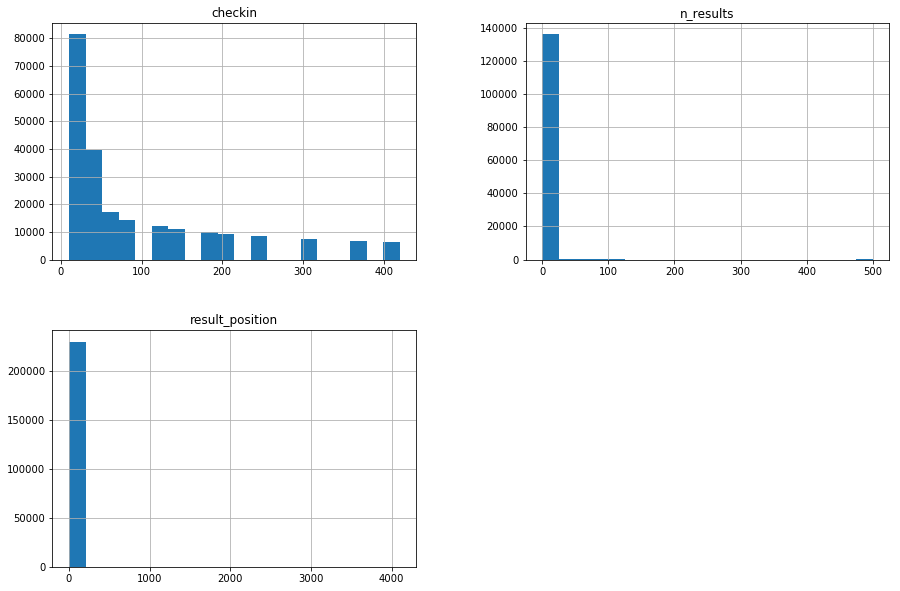

In [210]:
activity_df.hist(bins=20, figsize=(15, 10))

Looking at `checkin` values - which tell us how many seconds the page has been open for - we see that the vast majority of the distribution is concentrated aroung 0-100 secodns values. Only around 8000 of pages reachech 400 seconds sessions. The distribution looks really realitistic.

`n_results` (number of search hits returned to the user) distribution looks suspicious. As we mentioned earlier it is low likely that user will get 500 hits after the query or even if it is likely for some query it looks like outlier that we should get rid of before further analysis. Let's see how many large values like that we have. To classify as outlier let's use statistical rule: outlier if value is greater than 75% quantile value plus 1.5 of interquantile range.

In [211]:
iqr_n_results = activity_df["n_results"].quantile(0.75) - activity_df["n_results"].quantile(0.25)
outlier_threshold_n_results = activity_df["n_results"].quantile(0.75) + iqr_n_results
outlier_threshold_n_results

38.0

In [212]:
len(activity_df[activity_df["n_results"] > outlier_threshold_n_results])

360

We see that we have only - considering 400165 data records - 360 values above our outlier threshold which stretch our distribution to the right. The best thing for further analysis will be droping these outlier data records from our dataset. We also need to remember to keep `NaN` values here since they are also informative.

In [213]:
import numpy as np

activity_df = activity_df[(activity_df["n_results"] <= outlier_threshold) | (activity_df["n_results"].isnull())]
len(activity_df)

399805

Now it is time to look at `result_position` (the position of the visited page's link on the search engine results page ) distribution. As we saw previously its max value is 4103 and the distribution on the plot looks unrealistic. Either these value is an error or it is really unlikely outlier. Let's repeat the procedure - detecting outliers in the distribution - we did for `n_results`.

In [214]:
iqr_result_position = activity_df["result_position"].quantile(0.75) - activity_df["result_position"].quantile(0.25)
outlier_threshold_result_position = activity_df["result_position"].quantile(0.75) + iqr_result_position
outlier_threshold_result_position

3.0

Here our IQR based threshold is really small - that would result in large number of values being discarder. Let's then be really non-restrictive here and set threshold value to be 50. We are talking about the position of the visited page's link on the search engine results page. Chances for it to be more then 40 are really small. Let's see how small.

In [215]:
manual_outlier_threshold = 30
len(activity_df[activity_df["result_position"] > manual_outlier_threshold])

940

There are only 940 data records with values of `result_position` above 30 among 400165 data records. Probability of getting these values is 0.002 - very low probability. That means that for the sake of data clarity we can drop these outlier results.

In [216]:
activity_df = activity_df[(activity_df["result_position"] <= manual_outlier_threshold) | (activity_df["result_position"].isnull())]
len(activity_df)

398865

Now all looks good. Let's again look at our numerical attributes distributions.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x14ebe5ba8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x14d6af160>]], dtype=object)

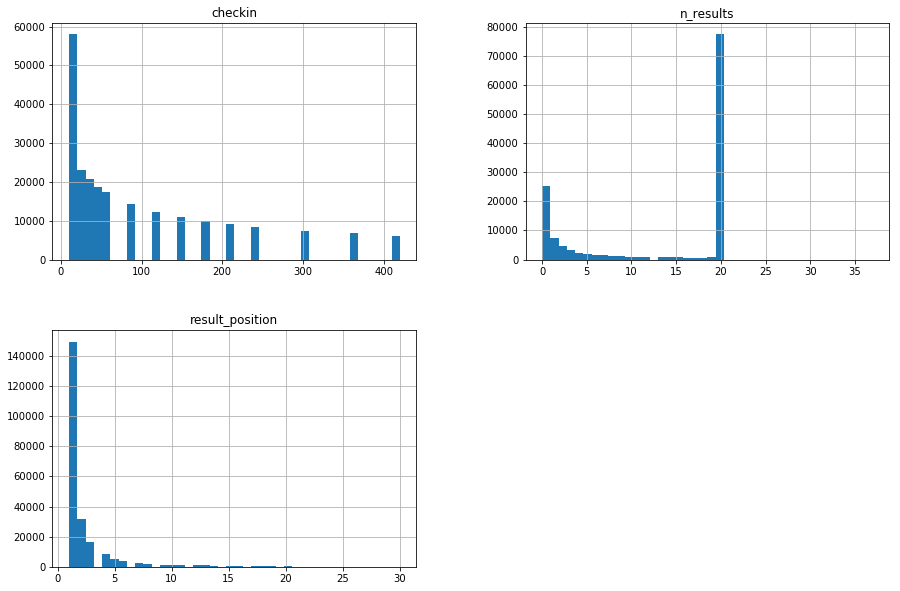

In [217]:
activity_df.hist(bins=40, figsize=(15, 10))

Now we are able to tell something more about our numerical attributes distributions. `n_results` (the number of hits returned to the user.) histogram, previously unreadable, now shows clearly what is going on. We see that vast majority of user searches get 20 results. It seems that data is somehow capped at this point - maybe by search meachanism - to that value which is indicated by this large peak in the middle of the distribution. This could be checked with engineers who created data logging mechanism - why is that happening?

Also we can see that there is quite a lot of searches resulting in one result. That could mean that the user looke for something really specific and search was so specific that it returned only one answer. The question to ask here would be whether it was the answer the user was looking for - namely whether she or he clicked it. This could be checked later on.

There are also in-between values. On one hand there are search results where user's query returned more than one but less then 20 results. And that is perfectly normal for searches which are less specific. On the other hand there are searches which resulted in more than 20 results. And there are around few hundreds of them meaning that they are somehow strange why they are happening so rarely or at all if it turned out that search results are in fact capped at max 20 results.

Going back to `result_position` - it now looks clear and seems to be fine. We can see that most of searches ends up with user clicking on the first link and if not the first five results are next to choose. Searches with clicked results of above result number 5 of the result list are marginal in number. That tells us that users find what they are looking for right in the to of their search result page. That is really impressive.

To finish this part of exploration we can also check our categorical attributes distributions.

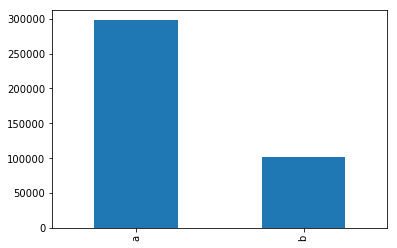

In [224]:
activity_df["group"].value_counts().plot(kind='bar')

We can see that vast majority of users belong to group A (300,000 vs. 100,000). So probably group B is experiment test group.

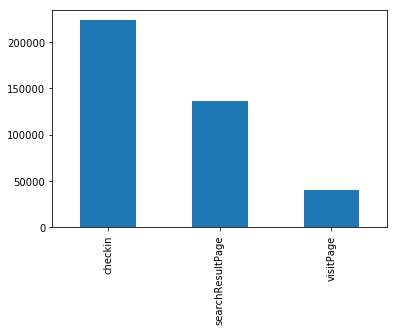

In [225]:
activity_df["action"].value_counts().plot(kind='bar')

Let's see what is going on in `action` (when the user has remained on the page for a pre-specified amount of time) attribute distribution. We have here kind of obvious fact that the majority of the user logs will be `checkin`  value (when the user has remained on the page for a pre-specified amount of time). Users spend most of the time reading the Wikipedia articles. More surprising can be quite a lot of `searchResultPage` (when a new search is performed and the user is shown a SERP). That means that users also use Wikipedia search feature really actively. However there is really low number of `visitPage` events (when the user clicks a link in the results). Theoretically every search result page view could end up clicking on one of the result. However since number of `visitPage` events is much lower comparing to `searchResultPage` means there are a lot of searches that does not end with clicking on any of the results - probably refining the query anr running search again. The question that could be asked here is how large is the number of searches which does not result in user clicking on any of the result. That could be infered indirectly by checking the difference between `searchResultPage` events number and `visitPage`. Let's do it.

In [230]:
val_counts = activity_df["action"].value_counts()
val_counts

checkin             223187
searchResultPage    135874
visitPage            39804
Name: action, dtype: int64

In [233]:
no_visit_count = val_counts["searchResultPage"] - val_counts["visitPage"]
no_visit_count

96070

In [235]:
no_visit_percent = no_visit_count / val_counts["searchResultPage"] * 100
no_visit_percent

70.705212181874387

That would mean that 96070 out of 135874 `searchResultPage` did not end with `visitPage` event meaning that 70% of all searches end up with not finding what the user was looking for and either droping the search or repeating the search with more detailed or modified query. That, comparing to above analysis of `result_position` attribute values is not so optimistic. All in all it means that if after searching something on Wikipedia user finds correct result and clicks on results page link, the result is most likely in the top 5 links. However in 70% of search cases user does not click any of returned result. That is not so effective as it looked before. We could further analyse this problem by searching for such (multiple failed searches) patterns in user logs events or use this value as one of the metrics we will construct to measure users behavior. Will focus on it a bit later in this analysis.